Here we will see how singular decompositions can be used for stock price prediction. For that we will need `quandl` library to be installed (see [here](https://github.com/quandl/quandl-python) for more details). 

In [221]:
from ssa_core import ssa, ssa_predict, ssaview, inv_ssa, ssa_cutoff_order
from mpl_utils import set_mpl_theme

import matplotlib.pylab as plt
import quandl
import pandas as pd
import datetime
from datetime import timedelta
from dateutil import parser


%matplotlib inline

# customize mpl a bit
set_mpl_theme('light')

# some handy functions
def fig(w=16, h=5, dpi=96, facecolor=None, edgecolor=None):
    return plt.figure(figsize=(w, h), dpi=dpi, facecolor=facecolor, edgecolor=edgecolor)

def mape(f, t):
    return 100*((f - t)/t).abs().sum()/len(t)

def mae(f, t):
    return 100*((f - t)).abs().sum()/len(t)

Now try to load adjusted close prices for MSFT from Quandl.

In [222]:
instrument = 'MSFT'
data = quandl.get('WIKI/%s' % instrument, start_date='2012-01-01', end_date='2017-02-01')
closes = data['Adj. Close'].rename('close')

We split series into train and test intervals and see how it looks on chart

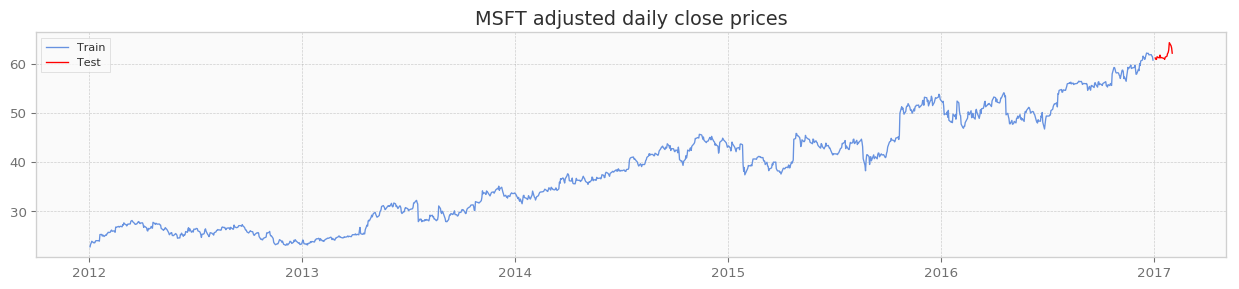

In [223]:
test_date = '2017-01-01'

train_d = closes[:test_date]
test_d = closes[test_date:]

fig(16, 3); plt.plot(train_d, label='Train'); plt.plot(test_d, 'r', label='Test')
plt.title('%s adjusted daily close prices' % instrument)
plt.legend()

We can see how SSA decomposes original series into trend components and noise. There is chart of original series, reconstructed from first 4 components and residuals.

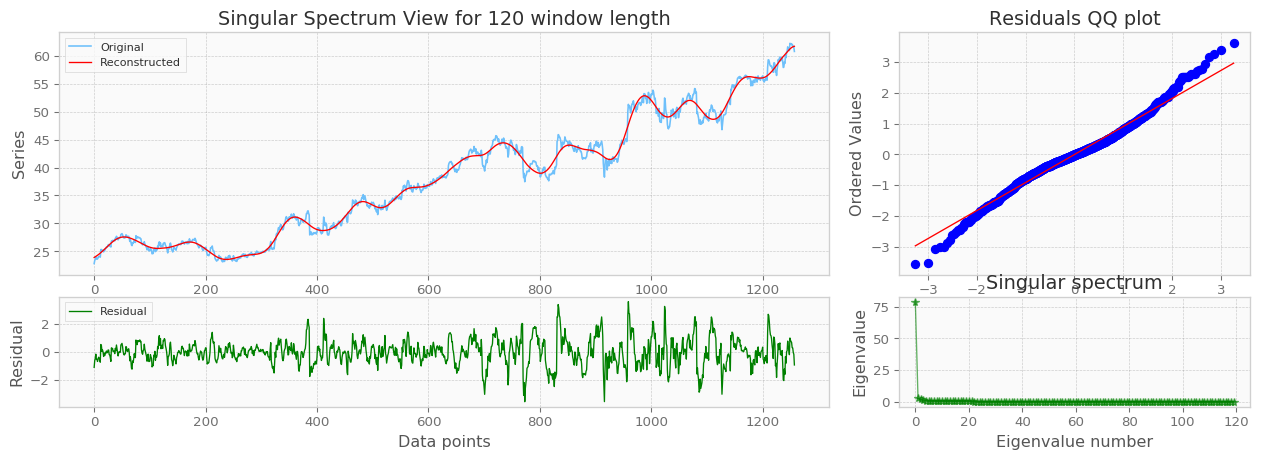

In [224]:
fig()
ssaview(train_d.values, 120, [0,1,2,3])

We can plot residuals plot using following code

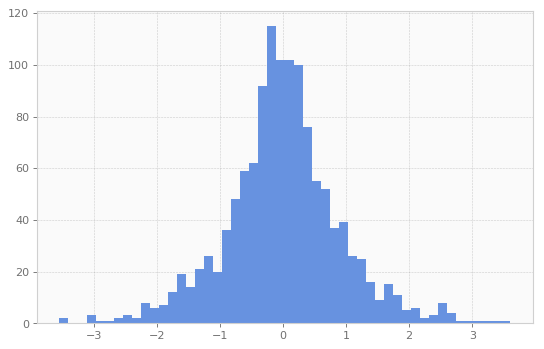

In [225]:
pc, _, v = ssa(train_d.values, 120)
reconstructed = inv_ssa(pc, v, [0,1,2,3])
noise = train_d.values - reconstructed
plt.hist(noise, 50);

It's possible to reduce embedding space dimension by finding minimal lag

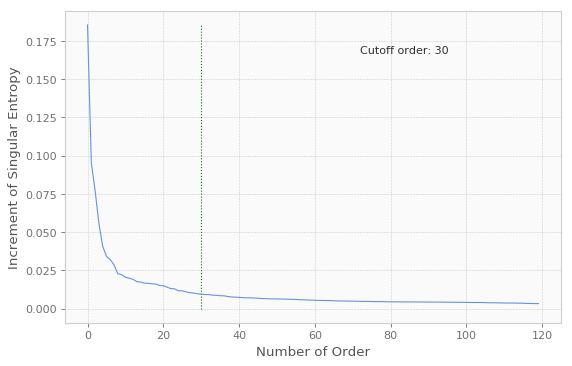

In [226]:
MAX_LAG_NUMBER = 120 # 4*30 = 1 quarter max
n_co = ssa_cutoff_order(train_d.values, dim=MAX_LAG_NUMBER, show_plot=True)

Using minimal lag we could try to make forecast for price series and plot results

In [227]:
days_to_predict = 15
forecast = ssa_predict(train_d.values, n_co, list(range(8)), days_to_predict, 1e-5)

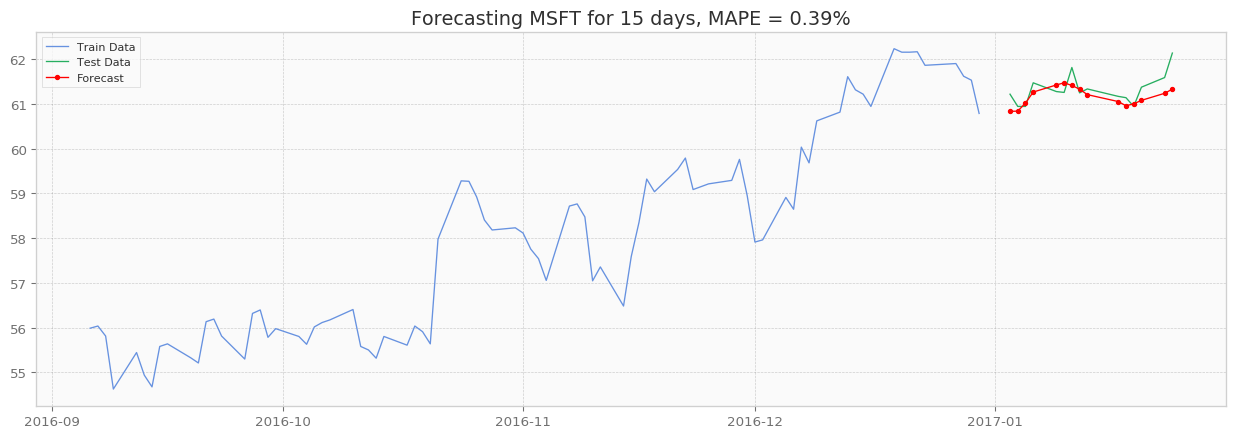

In [228]:
fig(16, 5)

prev_ser = closes[datetime.date.isoformat(parser.parse(test_date) - timedelta(120)):test_date]
plt.plot(prev_ser, label='Train Data')

test_d = closes[test_date:]
f_ser = pd.DataFrame(data=forecast, index=test_d.index[:days_to_predict], columns=['close'])
orig = pd.DataFrame(test_d[:days_to_predict])

plt.plot(orig, label='Test Data')
plt.plot(f_ser, 'r-', marker='.', label='Forecast')
plt.legend()
plt.title('Forecasting %s for %d days, MAPE = %.2f%%' % (instrument, days_to_predict, mape(f_ser, orig)));